# **High Value Customer Identification (Insiders)**

## Solution Planning

### Input

**1. Business Problem**
- Select the most valuable customers to join a loyalty program.

**2. Dataset**
- E-commerce sales throughout one year.

### Output

**1. A list with the seleced customers.**
   - Format: 
   
|      client_id  |   is_insider  |  
|:---------------:|:-------------:|
|  10323          |   yes/1       | 
|  32415		  |    no/1       | 

**2. Report with the business questions' answers:**
- Who are the eligible customers to the program?
- How many customers will be part of the group?
- What are the main characteristics of these customers?
- What is the percentage of revenue contribution from the Insiders?
- What is the expected revenue from the Insiders for the next few months?
- What are the conditions for a person to be eligible as an Insider?
- What are the conditions for a person to be removed from the Insiders?
- What is the guarantee that the Insiders are better than the rest?
- What actions could be done by the marketing team to increase the revenue?

### Tasks

**1. Who are the eligible customers to the program?**
- What is being eligible? What is "the most valuable customers"?
- Valuable customers as:
    - Revenue:
        - High average ticket;
        - High life time value (LTV);
        - Low recency;
        - High basket size;
        - Low churn probability;
        - High LTV prediction;
        - High propensity to buy.
        
    - Cost:
        - Low return rate.  
   
    - Shopping experience:
        - High evaluation score.

**2. How many customers will be part of the group?**
- Customers that are Insiders divided by total customers.

**3. What are the main attributes of these customers?**
- Get customers characteristcs, such as:
    - Age;
    - Location;
    - ...
- Get consuption characteristics, such as:
    - Clustering attributes.
    
    
**4. What is the percentage of revenue contribution from the Insiders?**
- Revenue contribution from the Insiders divided by total revenue.

**5. What is the expected revenue from the Insiders for the next few months?**
- Insiders' LTV;
- Cohort analysis.

**6. What are the conditions for a person to be eligible as an Insider?**
- Define periodicity;
- The person needs to be similiar to an Insider.


**7. What are the conditions for a person to be removed from the Insiders?**
- Define periodicity;
- The person needs to be different in a certain level to an Insider.

**8. What is the guarantee that the Insiders are better than the rest?**
- A/B Testing;
- A/B Bayesian Testing;
- Hypothesis Testing.

**9. What actions could be done by the marketing team to increase the revenue?**
- Discount;
- Purchase preference;
- Low shipping;
- ...

## Solution Benchmark

### RFM Model

**1. Recency:**
- Time since the last purchase;
- Responsiveness.

**2. Frequency:**
- Mean time between transactions;
- Engagement.

**3. Monetary:**
- Total spent;
- Revenue.

![](img/rfm.png)

**1. Champions**
- Recent and frequent purchases, with high value;
- Prizes for these customers.

**2. Potential Loyalists**
- Recent purchases, with a good frequency and good value;
- Loyalty program and Upsell.

**3. New Customers**
- Recent purchase and low frequency;
- Relationship building and offers.

**4. At Risk Customer**
- It has been a long time since the last purchase;
- Reactivation campaigns, offers and products.

**5. Can't Lose Them**
- Understand the causes and offer some benefits.

# 1. Imports

In [76]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
import umap.umap_   as umap
import warnings
import re

from matplotlib              import pyplot        as plt
from plotly                  import express       as px
from sklearn                 import preprocessing as pp

from pandas_profiling        import ProfileReport
from IPython.core.display    import HTML
from IPython.display         import Image

from sklearn.metrics         import silhouette_score
from sklearn.cluster         import KMeans
from sklearn.preprocessing   import MinMaxScaler
from sklearn.decomposition   import PCA
from sklearn.manifold        import TSNE
from sklearn.ensemble        import RandomForestRegressor

from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer

## 1.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,8]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:80% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")
    
    
    warnings.filterwarnings('ignore')

In [3]:
jupyter_settings()

## 1.2. Load Dataset

In [4]:
# load data
df_raw = pd.read_csv( '../data/Ecommerce.csv',  encoding= 'unicode_escape' )

# drop extra column
df_raw.drop( columns='Unnamed: 8', axis=1, inplace=True)

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 2. Data Description

In [6]:
df2 = df_raw.copy()

## 2.1. Rename Columns

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

# rename columns
df2.columns = cols_new
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 2.2. Data Dimensions

In [8]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 541909
Number of columns: 8


## 2.3. Data Types

In [9]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4. Check NA

In [10]:
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 2.5. Replace NA

In [11]:
df_missing = df2.loc[df2['customer_id'].isna(), :]
df_not_missing = df2.loc[~df2['customer_id'].isna(), :]

In [12]:
# max customer_id
df_not_missing['customer_id'].max()

18287.0

In [13]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000 + len(df_backup), 1 )
df_backup.head()

,invoice_no,customer_id
622,536414,19000
1443,536544,19001
1970,536545,19002
1971,536546,19003
1972,536547,19004


In [14]:
# merge original with reference
df2 = pd.merge( df2, df_backup, on='invoice_no', how='left' )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id_x,country,customer_id_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [15]:
# coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first( df2['customer_id_y'] )

# drop extra columns
df2.drop( columns=['customer_id_x', 'customer_id_y'], axis=1, inplace=True )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [16]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [17]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

## 2.6. Change dtypes

In [18]:
# invoice date
df2['invoice_date'] = pd.to_datetime( df2['invoice_date'], format='%d-%b-%y' )

# customer_id
df2['customer_id'] = df2['customer_id'].astype( int )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [19]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 2.7. Descriptive Statistics

In [20]:
num_attributes = df2.select_dtypes( include=['int32', 'int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int32', 'int64', 'float64', 'datetime64[ns]'] )

### 2.7.1. Numerical Attributes

In [21]:
# central tendency
_mean   = pd.DataFrame( num_attributes.apply( np.mean ) ).T
_median = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion
_std   = pd.DataFrame( num_attributes.apply( np.std ) ).T
_min   = pd.DataFrame( num_attributes.apply( np.min ) ).T
_max   = pd.DataFrame( num_attributes.apply( np.max ) ).T
_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
_skew  = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
_kurtosis  = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
summary = pd.concat( [_min, _max, _range, _mean, _median, _std, _skew, _kurtosis] ).T.reset_index()
summary.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


* **Negative quantity** - It could mean a returning.
* **Unit price equal to zero** - Could it mean a promotion?

### 2.7.2. Categorical Attributes

In [22]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### 2.7.2.1. Invoice_no

In [23]:
# cat_attributes['invoice_no'].astype( int ) # It throws an error
index = df2['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) )
df2[index].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,United Kingdom,17548
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,United Kingdom,17548
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,United Kingdom,17548
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2016-11-29,4.25,United Kingdom,17897


In [24]:
# unique values
len( df2.loc[index, 'invoice_no'].drop_duplicates()  )

3839

In [25]:
# checking if all invoices with a letter indicates has a negative quantity
df_letter_invoices = df2[index]
print( 'Total number of invoices with a letter: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of invoices with a letter and negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices with a letter: 9291
Total number of invoices with a letter and negative quantity: 9288


#### 2.7.2.2. Stock_code

In [26]:
index = df2['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+.*$', x ) ) )
df2[index].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1423,536540,C2,CARRIAGE,1,2016-11-29,50.00,EIRE,14911
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001
2239,536569,M,Manual,1,2016-11-29,1.25,United Kingdom,16274
2250,536569,M,Manual,1,2016-11-29,18.95,United Kingdom,16274
3041,536592,DOT,DOTCOM POSTAGE,1,2016-11-29,607.49,United Kingdom,19014
4406,536779,BANK CHARGES,Bank Charges,1,2016-11-30,15.00,United Kingdom,15823


In [27]:
# unique values
print( len( df2.loc[index, 'stock_code'].drop_duplicates() ) )
print( df2.loc[index, 'stock_code'].unique())

33
['POST' 'D' 'C2' 'DOT' 'M' 'BANK CHARGES' 'S' 'AMAZONFEE' 'DCGS0076'
 'DCGS0003' 'gift_0001_40' 'DCGS0070' 'm' 'gift_0001_50' 'gift_0001_30'
 'gift_0001_20' 'DCGS0055' 'DCGS0072' 'DCGS0074' 'DCGS0069' 'DCGS0057'
 'DCGSSBOY' 'DCGSSGIRL' 'gift_0001_10' 'PADS' 'DCGS0004' 'DCGS0073'
 'DCGS0071' 'DCGS0068' 'DCGS0067' 'DCGS0066P' 'B' 'CRUK']


#### 2.7.2.3. Country

In [28]:
df2['country'].value_counts( normalize=True )

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

# 3. Data Filtering

In [29]:
df3 = df2.copy()

## 3.1. Numerical Attributes

In [30]:
# unit price > 0
df3 = df3.loc[ df3['unit_price'] > 0.010, : ]

# stock code == number
df3 = df3[~df3['stock_code'].isin( ['POST', 'D', 'C2', 'DOT', 'M', 'BANK, CHARGES', 'S', 'AMAZONFEE', 'DCGS0076'
, 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm', 'gift_0001_50', 'gift_0001_30'
, 'gift_0001_20', 'DCGS0055', 'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057'
, 'DCGSSBOY', 'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073'
, 'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'] )]

# quantity - negative numbears means product returns
df3_returns = df3.loc[df3['quantity'] < 0, :]
df3_purchases = df3.loc[df3['quantity'] > 0, :]

## 3.2. Categorical Attributes

In [31]:
# drop description
df3 = df3.drop( columns='description', axis=1 )

In [32]:
# map
df3 = df3[~df3['country'].isin( ['European Community', 'Unspecified'] )]

# 4. Feature Engineering

In [33]:
df4 = df3.copy()
df_purchases = df3_purchases.copy()
df_returns = df3_returns.copy()

## 4.1. Feature Creation

The dataset granularity should be customers, because the clusters will be for customers, but it is a unique key composed of product (stock_code) and date (invoice_date). So it is necessary to change the granularity.

In [34]:
# data reference
df_ref = df4[['customer_id']].drop_duplicates( ignore_index=True )
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 4.1.1. Gross Revenue

In [35]:
# Gross Revenue (quantity * price)
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']

# Monetary
df_monetary = df_purchases[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id',  how='left')
df_ref.head()

,customer_id,gross_revenue
0,17850,5391.21
1,13047,3232.59
2,12583,6705.38
3,13748,948.25
4,15100,876.00


### 4.1.2. Recency - Day from last purchase

In [36]:
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days
0,17850,5391.21,372.0
1,13047,3232.59,56.0
2,12583,6705.38,2.0
3,13748,948.25,95.0
4,15100,876.00,333.0


### 4.1.3. Quantity of purchases

In [37]:
df_freq = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().rename( columns={"invoice_no":"qtd_purchases"}).reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases
0,17850,5391.21,372.0,34.0
1,13047,3232.59,56.0,9.0
2,12583,6705.38,2.0,15.0
3,13748,948.25,95.0,5.0
4,15100,876.00,333.0,3.0


### 4.1.4. Quantity of Items Purchased

In [38]:
df_freq = df_purchases[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().rename( columns={"quantity":"qtd_items"}).reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items
0,17850,5391.21,372.0,34.0,1733.0
1,13047,3232.59,56.0,9.0,1390.0
2,12583,6705.38,2.0,15.0,5028.0
3,13748,948.25,95.0,5.0,439.0
4,15100,876.00,333.0,3.0,80.0


### 4.1.5. Quantity of Products Purchased

In [39]:
df_freq = df_purchases[['customer_id', 'stock_code']].groupby( 'customer_id' ).count().rename( columns={"stock_code":"qtd_products"}).reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products
0,17850,5391.21,372.0,34.0,1733.0,297.0
1,13047,3232.59,56.0,9.0,1390.0,171.0
2,12583,6705.38,2.0,15.0,5028.0,232.0
3,13748,948.25,95.0,5.0,439.0,28.0
4,15100,876.00,333.0,3.0,80.0,3.0


### 4.1.6. Average Ticket Value

In [40]:
df_avg_ticket = df_purchases[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().rename( columns={"gross_revenue":"avg_ticket"} ).reset_index()
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000


### 4.1.7. Average Recency Days

In [41]:
df_aux = df_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[True, True] )
df_aux['previous_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply( lambda x: (x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['previous_customer_id'] else np.nan, axis=1 ) 

df_aux = df_aux.drop( ['invoice_date', 'previous_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency
df_avg_rec_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_rec_days, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,1.000000
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,52.833333
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,26.500000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,20.000000


### 4.1.8. Returns

In [42]:
df_ret = df_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={"quantity":"qtd_returns"} )
df_ret['qtd_returns'] = df_ret['qtd_returns'] * -1
df_ref = pd.merge( df_ref, df_ret, how='left', on='customer_id' )
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,1.000000,40.0
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,52.833333,35.0
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,26.500000,50.0
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.0
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,20.000000,22.0


### 4.1.9. Frequency Purchase

In [43]:
df_aux = ( df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                      .groupby( 'customer_id' )
                                                                      .agg( max_date = ('invoice_date', 'max'),
                                                                            min_date = ('invoice_date', 'min'),
                                                                            days     = ('invoice_date', lambda x: (( x.max() - x.min() ).days) + 1 ),
                                                                            buy      = ('invoice_no', 'count') ) ).reset_index()

# frequency 
df_aux['frequency'] = df_aux[['buy', 'days']].apply( lambda x: x['buy'] / x['days'] if x['days'] != 0 else 0, axis=1 )

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns,frequency
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,1.000000,40.0,17.000000
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,52.833333,35.0,0.028302
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,26.500000,50.0,0.040323
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.0,0.017921
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,20.000000,22.0,0.073171


### 4.1.10. Average Basket Size

In [44]:
df_aux = ( df_purchases.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                        .agg( n_purchases=('invoice_no', 'nunique'), n_products =('quantity', 'sum'))
                                                                        .reset_index() )

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns,frequency,avg_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,1.000000,40.0,17.000000,50.970588
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,52.833333,35.0,0.028302,154.444444
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,26.500000,50.0,0.040323,335.200000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.0,0.017921,87.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,20.000000,22.0,0.073171,26.666667


### 4.1.11. Average Unique Basket Size

In [45]:
df_aux = ( df_purchases.loc[:,['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                        .agg( n_purchases=('invoice_no', 'nunique'), n_products =('stock_code', 'count'))
                                                                        .reset_index() )

df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns,frequency,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,1.000000,40.0,17.000000,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,52.833333,35.0,0.028302,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,26.500000,50.0,0.040323,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.0,0.017921,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,20.000000,22.0,0.073171,26.666667,1.000000


## 4.2. Checking NAs

In [46]:
# checking possible NAs created by the merge
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtd_purchases               91
qtd_items                   91
qtd_products                91
avg_ticket                  91
avg_recency_days          3013
qtd_returns                  0
frequency                   91
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 5. EDA

In [47]:
df5 = df_ref.dropna().copy()

In [48]:
df5.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtd_purchases             0
qtd_items                 0
qtd_products              0
avg_ticket                0
avg_recency_days          0
qtd_returns               0
frequency                 0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 5.1. Univariate Analysis

In [49]:
#profile = ProfileReport( df5, pool_size = 1 )
#profile.to_file( 'output.html' )

### 5.1.1. Gross Revenue

In [50]:
df5.sort_values( 'gross_revenue', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns,frequency,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,8.022727,288.0,0.203390,2733.944444,28.611111
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.0,0.163043,1068.733333,7.183333
434,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,13.807692,952.0,0.127778,1521.586957,7.326087
3338,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,80995.0,0.009709,40498.500000,1.500000
66,14911,136275.72,1.0,198.0,80179.0,5589.0,24.382845,2.883721,3331.0,0.530831,404.944444,28.227273


### 5.1.2. Quantity of Items Purchased

In [51]:
df5.sort_values( 'qtd_items', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns,frequency,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,8.022727,288.0,0.203390,2733.944444,28.611111
3338,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,80995.0,0.009709,40498.500000,1.500000
66,14911,136275.72,1.0,198.0,80179.0,5589.0,24.382845,2.883721,3331.0,0.530831,404.944444,28.227273
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,22.357143,427.0,0.063694,3868.650000,35.650000
434,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,13.807692,952.0,0.127778,1521.586957,7.326087


### 5.1.3. Quantity of Products Purchased

In [52]:
df5.sort_values( 'qtd_products', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns,frequency,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,3.351351,203.0,0.332440,185.911290,63.209677
66,14911,136275.72,1.0,198.0,80179.0,5589.0,24.382845,2.883721,3331.0,0.530831,404.944444,28.227273
4406,14096,53258.43,4.0,17.0,16336.0,5095.0,10.453078,6.062500,0.0,0.173469,960.941176,299.705882
47,12748,32317.32,0.0,206.0,25511.0,4580.0,7.056183,3.330357,1535.0,0.550802,123.839806,22.233010
96,14606,12021.65,1.0,91.0,6215.0,2698.0,4.455764,4.275862,245.0,0.243968,68.296703,29.648352


### 5.1.4. Average Ticket Value

In [53]:
df5.sort_values( 'avg_ticket', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns,frequency,avg_basket_size,avg_unique_basket_size
3338,16446,168472.50,0.0,2.0,80997.0,3.0,56157.5000,205.0,80995.0,0.009709,40498.500000,1.500000
1262,15749,44534.30,235.0,3.0,18028.0,10.0,4453.4300,97.0,9014.0,0.030612,6009.333333,3.333333
1136,16532,6748.80,17.0,3.0,2016.0,4.0,1687.2000,160.5,0.0,0.009317,672.000000,1.333333
601,12755,3811.95,280.0,2.0,1491.0,4.0,952.9875,85.0,624.0,0.023256,745.500000,2.000000
3780,12798,6977.04,10.0,3.0,5256.0,8.0,872.1300,80.0,0.0,0.018634,1752.000000,2.666667


In [54]:
# customer 16446
df4[df4['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


* We can see that the customer bought 80995 items of a product and returned it in the same day, a strange behavior.

## 5.2. Bivariate Analysis

In [55]:
cols = ['customer_id']
df52 = df5.drop( cols, axis=1 )

<Figure size 1800x864 with 0 Axes>

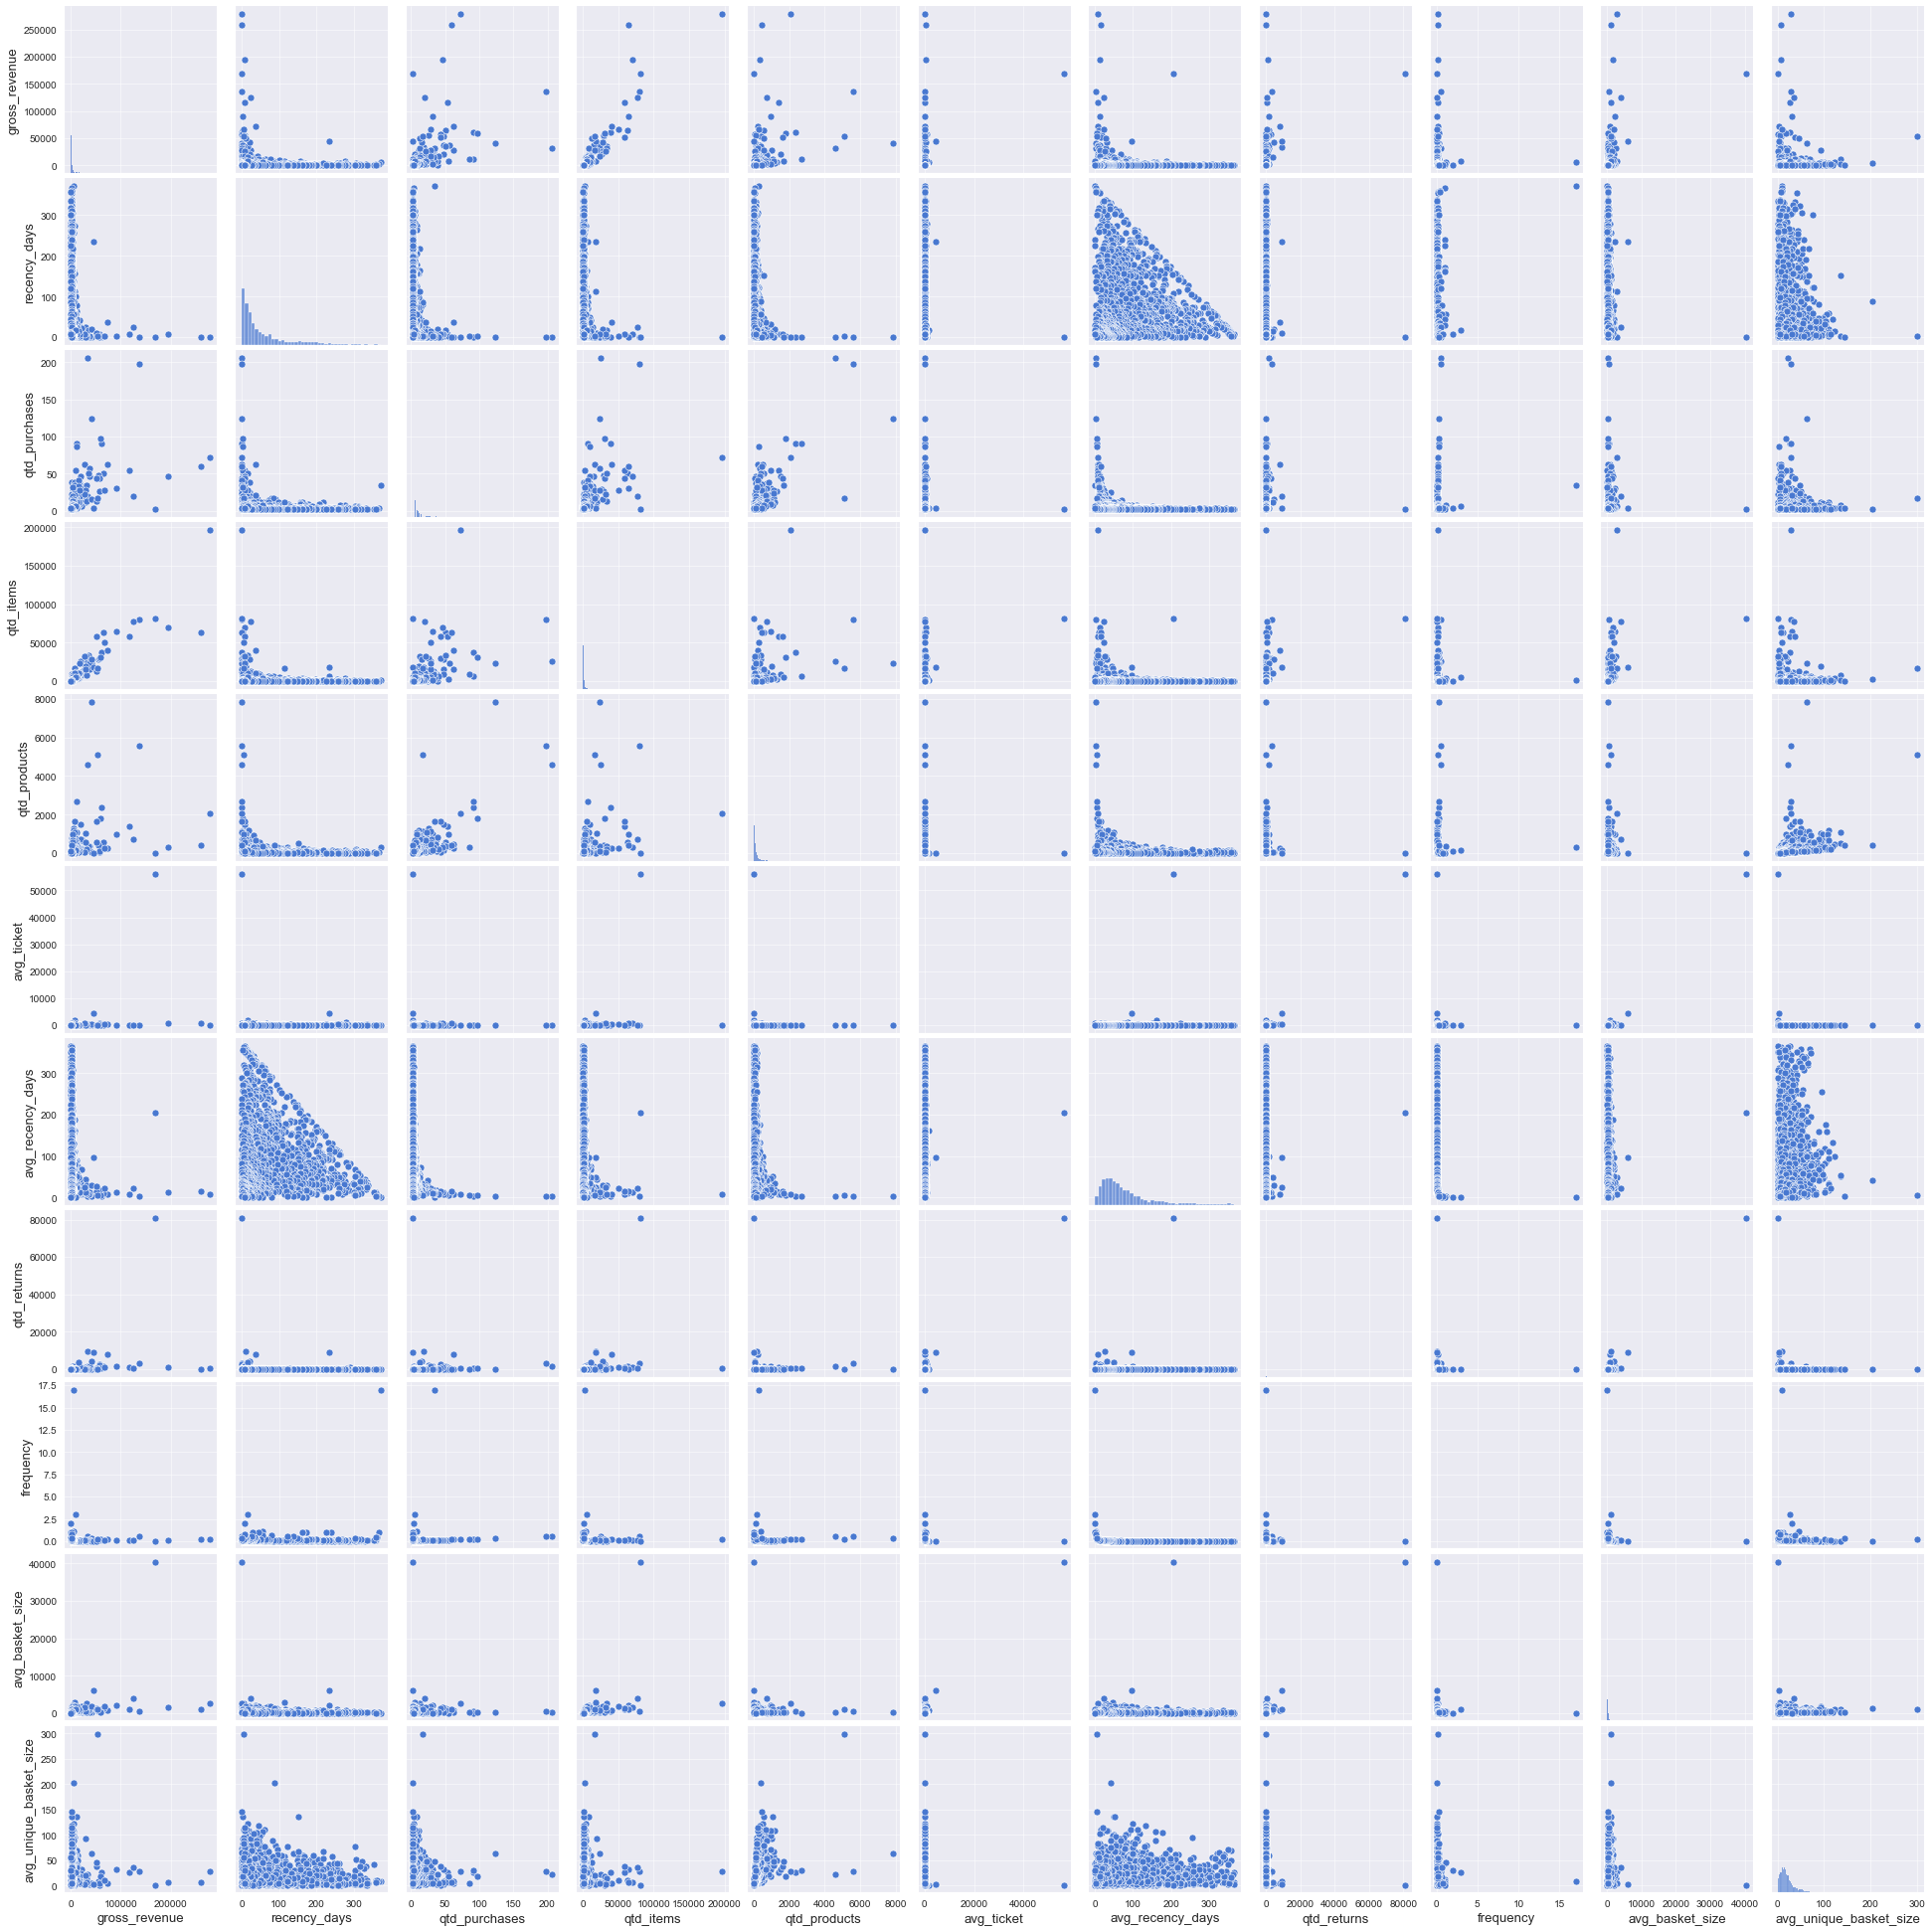

In [56]:
plt.figure( figsize=(25,12) )
sns.pairplot( df52 );

In [57]:
columns_not_selected = ['avg_ticket', 'frequency_purchase', 'recency_days', 'qtd_invoices', 'qtd_products']

## 5.3. Data Space

In [63]:
df53 = df5.drop( columns=['customer_id'], axis=1 ).copy()

In [64]:
mm = MinMaxScaler()

df53['gross_revenue']          = mm.fit_transform( df53[['gross_revenue']] )
df53['recency_days']           = mm.fit_transform( df53[['recency_days']] )
df53['qtd_purchases']          = mm.fit_transform( df53[['qtd_purchases']] )
df53['qtd_items']              = mm.fit_transform( df53[['qtd_items']] )
df53['qtd_products']           = mm.fit_transform( df53[['qtd_products']] )
df53['avg_ticket']             = mm.fit_transform( df53[['avg_ticket']] )
df53['avg_recency_days']       = mm.fit_transform( df53[['avg_recency_days']] )
df53['qtd_returns']            = mm.fit_transform( df53[['qtd_returns']] )
df53['frequency']              = mm.fit_transform( df53[['frequency']] )
df53['avg_basket_size']        = mm.fit_transform( df53[['avg_basket_size']] )
df53['avg_unique_basket_size'] = mm.fit_transform( df53[['avg_unique_basket_size']] )

X = df53.copy()

### 5.3.1. PCA

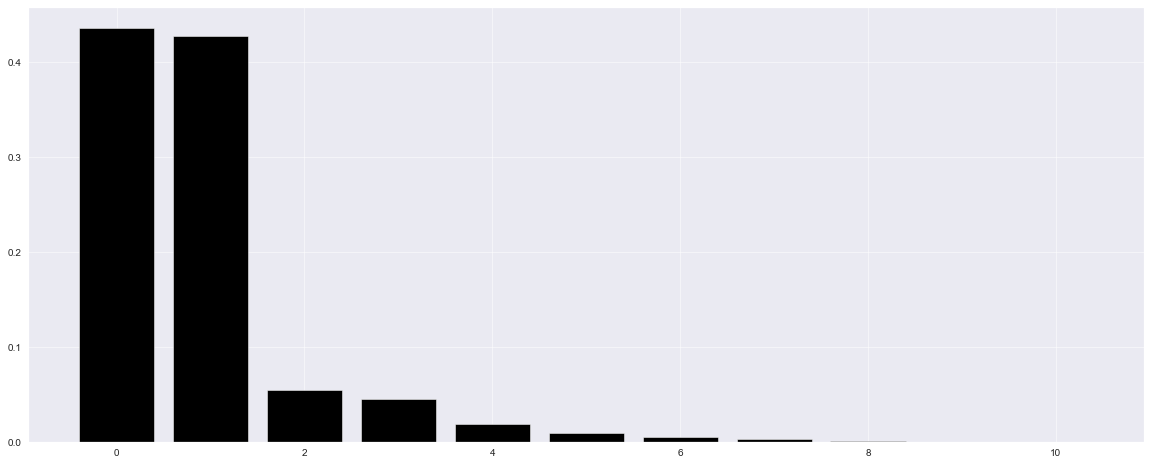

In [68]:
pca = PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

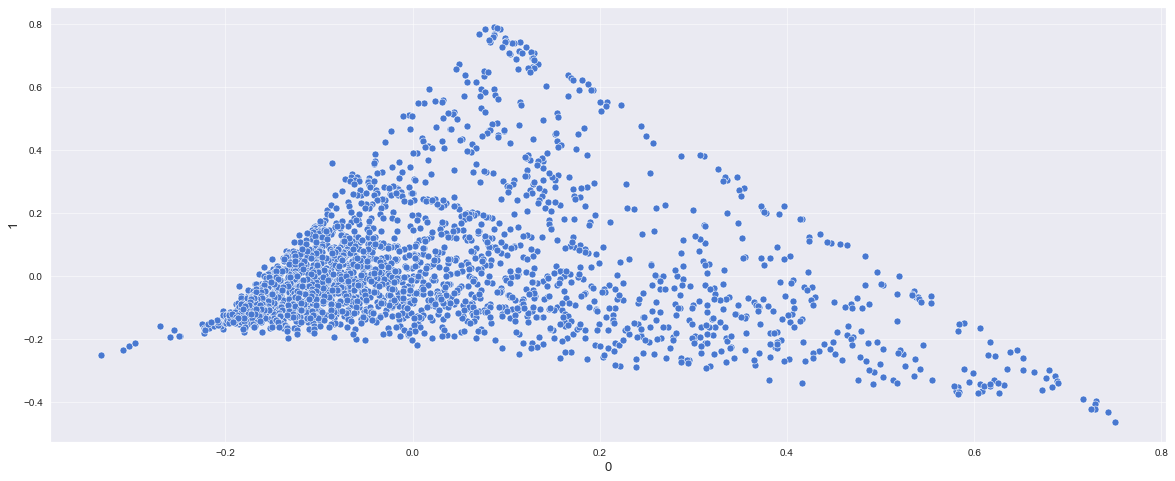

In [69]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 5.3.2. UMAP

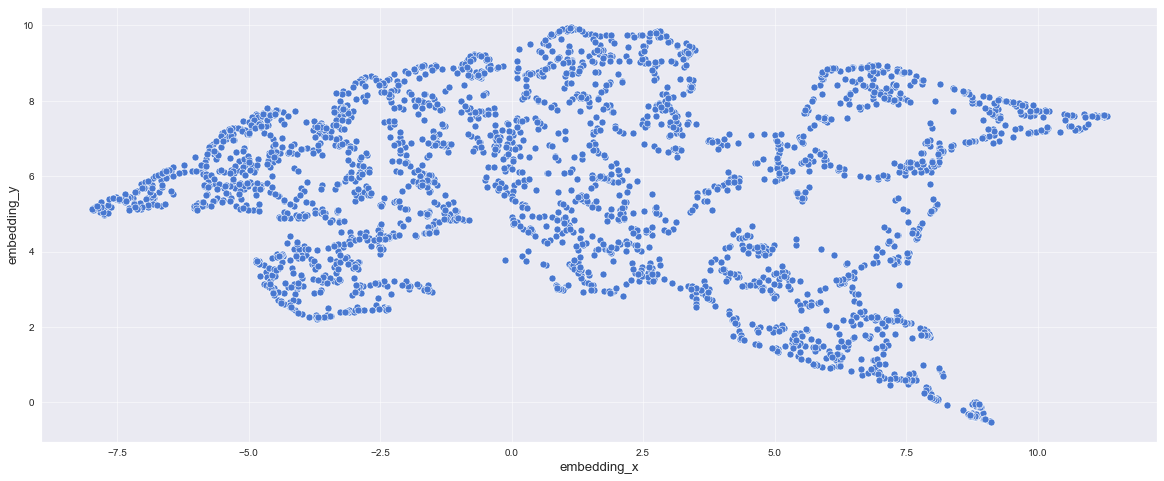

In [71]:
reducer = umap.UMAP( random_state=0 )
embedding = reducer.fit_transform( X )

# embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_pca )
plt.show();

### 5.3.3. t-SNE

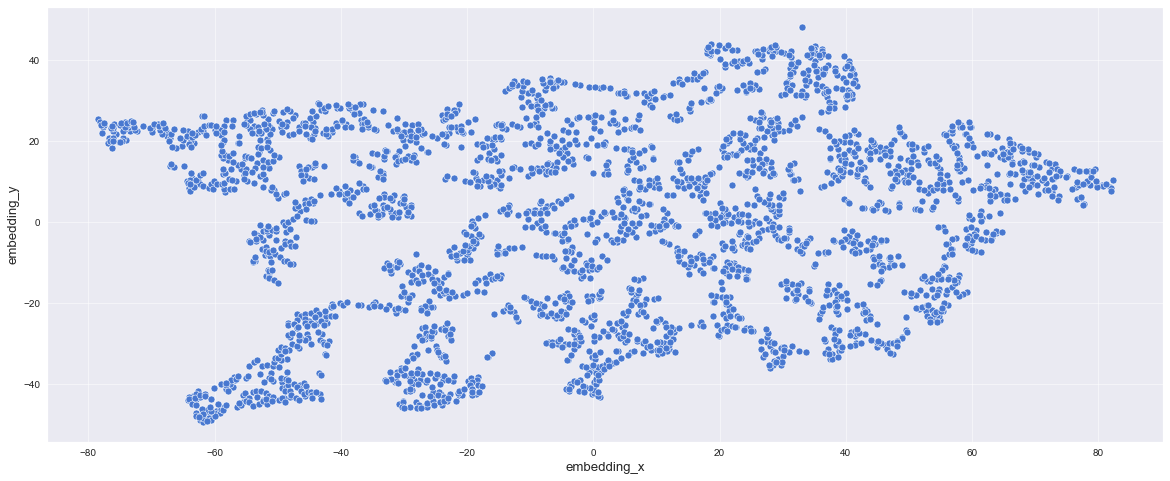

In [74]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state=0 )
embedding = reducer.fit_transform( X )

# embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot t-SNE
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_pca )
plt.show();

### 5.3.4. Tree-Based Embedding

In [75]:
# training dataset
X = df5.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df5['gross_revenue']

In [78]:
# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=0 )

# model training
rf_model.fit( X, y );

RandomForestRegressor(random_state=0)

In [79]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )
df_leaf.shape

(2774, 100)

In [80]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2864,2989,2766,2907,2771,2926,2861,3030,2766,3009,2888,2709,2919,2789,2902,3090,3138,2695,2741,2954,2636,2943,2949,2959,2928,3144,2893,2837,2669,2994,3001,2900,2864,3110,2704,2883,3006,2925,3028,3026,2914,2923,3086,2970,2760,2983,3004,2980,3072,2958,3035,2865,2909,2684,3004,3043,2816,3109,2917,2813,2867,2596,2852,3089,3104,2906,3079,3003,2868,2835,2642,3057,2907,3045,2795,3137,2914,3067,2929,3069,2872,2861,2816,2905,2897,2879,2950,2792,2840,2968,2952,2964,2750,2816,2959,2481,2859,3014,3013,2914
1,2807,2719,2808,2887,2595,2716,2325,2629,2764,2672,2863,2674,2555,2754,2912,2710,2668,2623,2730,2902,2614,2885,2863,2858,2878,2705,2553,2922,2433,2707,2961,2873,2634,2716,2620,2850,2664,2596,2714,2707,2861,2907,2759,2650,2851,2750,2708,2696,2670,2899,2657,2543,2845,2813,2704,2676,2816,2706,2766,2904,2466,2518,2716,2779,2690,2699,2690,2685,2761,2802,2589,2999,2868,2672,2551,2713,2868,2677,2851,2821,2769,2765,2755,2862,2813,2950,2934,2787,2810,2941,2739,2889,2871,2799,2931,2841,2688,2732,2704,2906
2,3343,3366,3323,3350,3349,3307,3373,3360,3329,3324,3354,3246,3339,3297,3340,3345,3359,3394,3380,3340,3189,3362,3389,3365,3365,3218,3332,3358,3248,3344,3443,3283,3323,3351,3301,3334,3258,3386,3240,3388,3324,3379,3403,3153,3371,3361,3338,3343,3263,3336,3361,3283,3254,3325,3315,3311,3424,3233,3469,3331,3279,3333,3356,3350,3335,3320,3348,3296,3426,3372,3356,3255,3374,3274,3375,3397,3304,3262,3356,3194,3341,3342,3442,3382,3336,3359,3375,3289,3424,3458,3400,3404,3359,3262,3249,3196,3366,3284,3351,3361
3,1897,1793,1426,1801,1096,1277,2145,1220,1707,1949,1569,1276,1304,1516,1513,1258,1168,1638,1279,1157,1128,1149,1527,1169,1443,1069,1786,2161,1297,1207,1379,1321,1551,1651,1135,1505,1330,1815,1374,2179,1601,1247,2043,2011,1208,1276,1666,1589,1114,1545,1244,1087,1555,1350,1109,1552,1103,1254,1209,1597,1876,1781,1312,1865,1368,1250,1248,1335,1866,1456,1270,1092,1130,1618,1270,1294,1189,1653,1356,1511,1327,1477,1235,1526,1225,1284,1977,1490,1273,1584,1636,1792,1741,1331,1433,1533,1611,1336,1323,1749
4,558,423,217,160,143,622,575,570,451,501,416,443,720,426,126,460,579,576,574,120,684,577,419,147,481,530,153,142,791,486,455,718,538,459,539,410,722,451,667,485,465,473,511,550,443,421,502,460,630,558,440,452,447,606,577,621,633,157,609,566,484,89,754,448,718,733,447,642,674,415,586,651,475,479,584,468,470,655,445,422,140,513,532,439,455,401,469,532,621,496,497,498,490,454,442,342,571,751,714,125


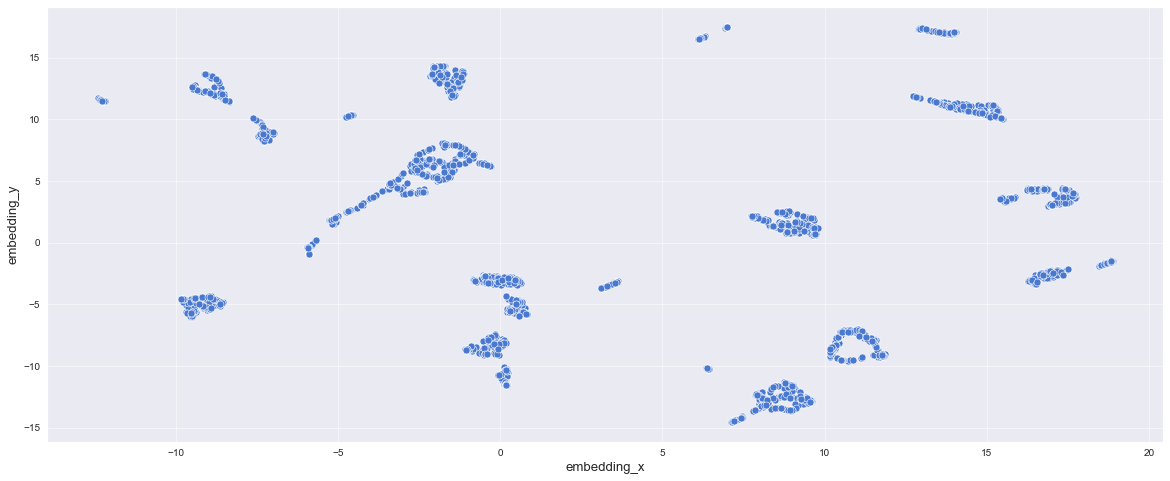

In [82]:
# reduce dimensionality
reducer = umap.UMAP( random_state=0 )
embedding = reducer.fit_transform( df_leaf )

# embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_pca )
plt.show();

# 6. Data Preparation

In [142]:
df6 = df5.copy()

In [143]:
ss = pp.StandardScaler()

df6['gross_revenue'] = ss.fit_transform( df6[['gross_revenue']] )
df6['recency_days'] = ss.fit_transform( df6[['recency_days']] )
df6['frequency'] = ss.fit_transform( df6[['frequency']] )
df6['avg_ticket'] = ss.fit_transform( df6[['avg_ticket']] )
df6['qtd_returns'] = ss.fit_transform( df6[['qtd_returns']] ) 

# 7. Feature Selection

In [ ]:
df7 = df6.copy()

# 8. Hyperparameter Fine-Tunning

In [58]:
X = df7.drop( columns=['customer_id'] )

clusters = [2, 3, 4, 5, 6, 7, 8, 9] 

## 8.1. Within-Cluster Sum of Squares ( WSS ) ( Elbow Method )

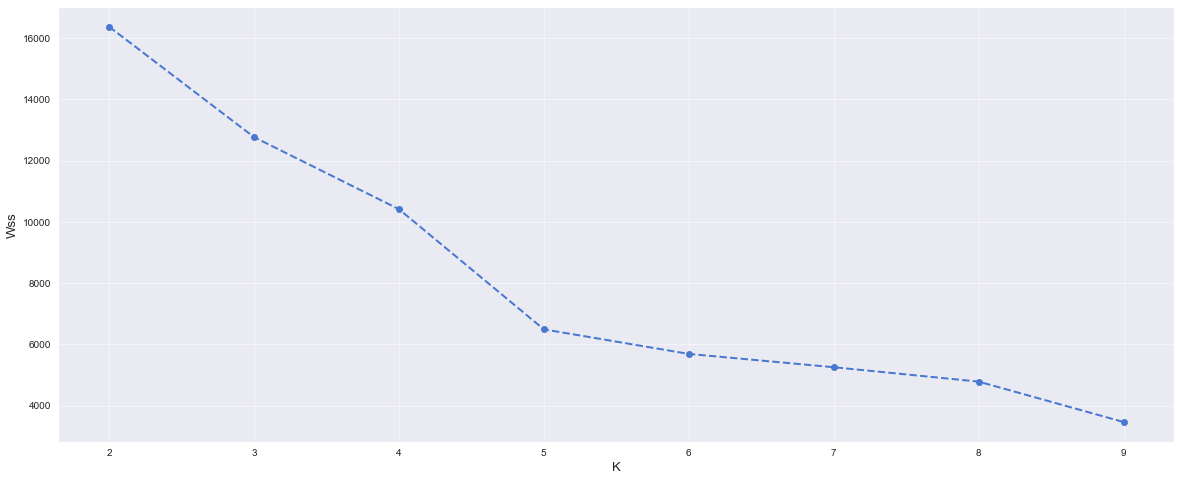

In [63]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=0 )
    
    # model training
    kmeans.fit( X )
    
    # validation
    wss.append( kmeans.inertia_ )
    
# plot wss
plt.plot( clusters, wss, linestyle='--', marker='o' )
plt.xlabel( 'K' )
plt.ylabel( 'Wss' );

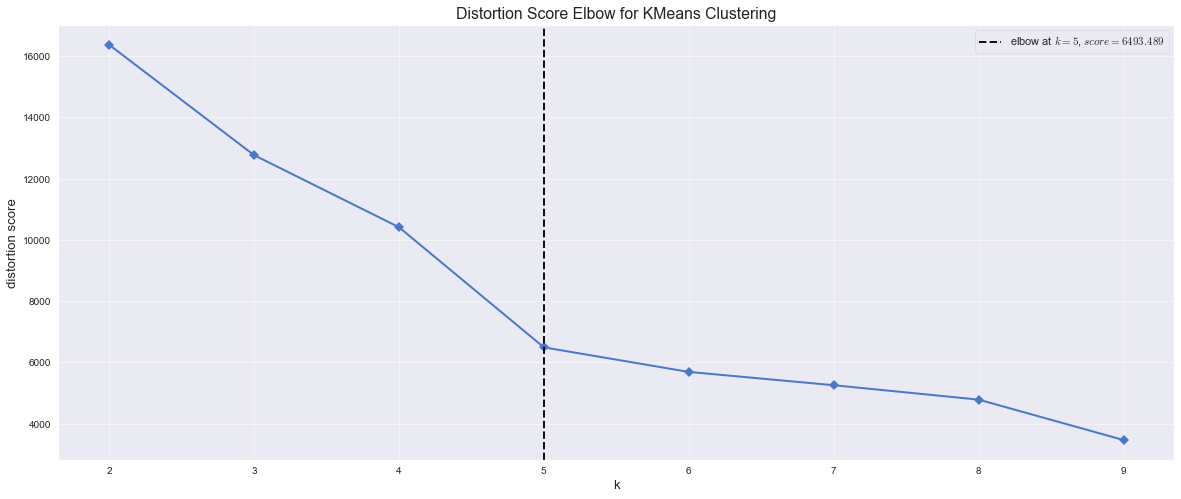

In [64]:
kmeans = KElbowVisualizer( KMeans( init='random', n_init=10, max_iter=300, random_state=0 ), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show();

## 8.2. Silhouette Score

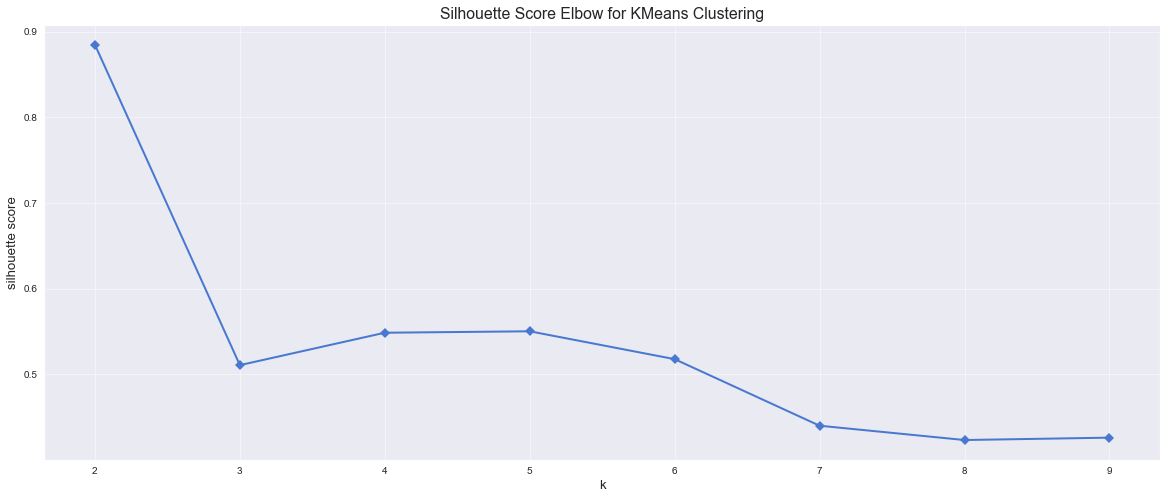

In [65]:
kmeans = KElbowVisualizer( KMeans( init='random', n_init=10, max_iter=300, random_state=0  ), k=clusters, timings=False, metric='silhouette' )
kmeans.fit( X )
kmeans.show();

## 8.3. Silhouette Analysis

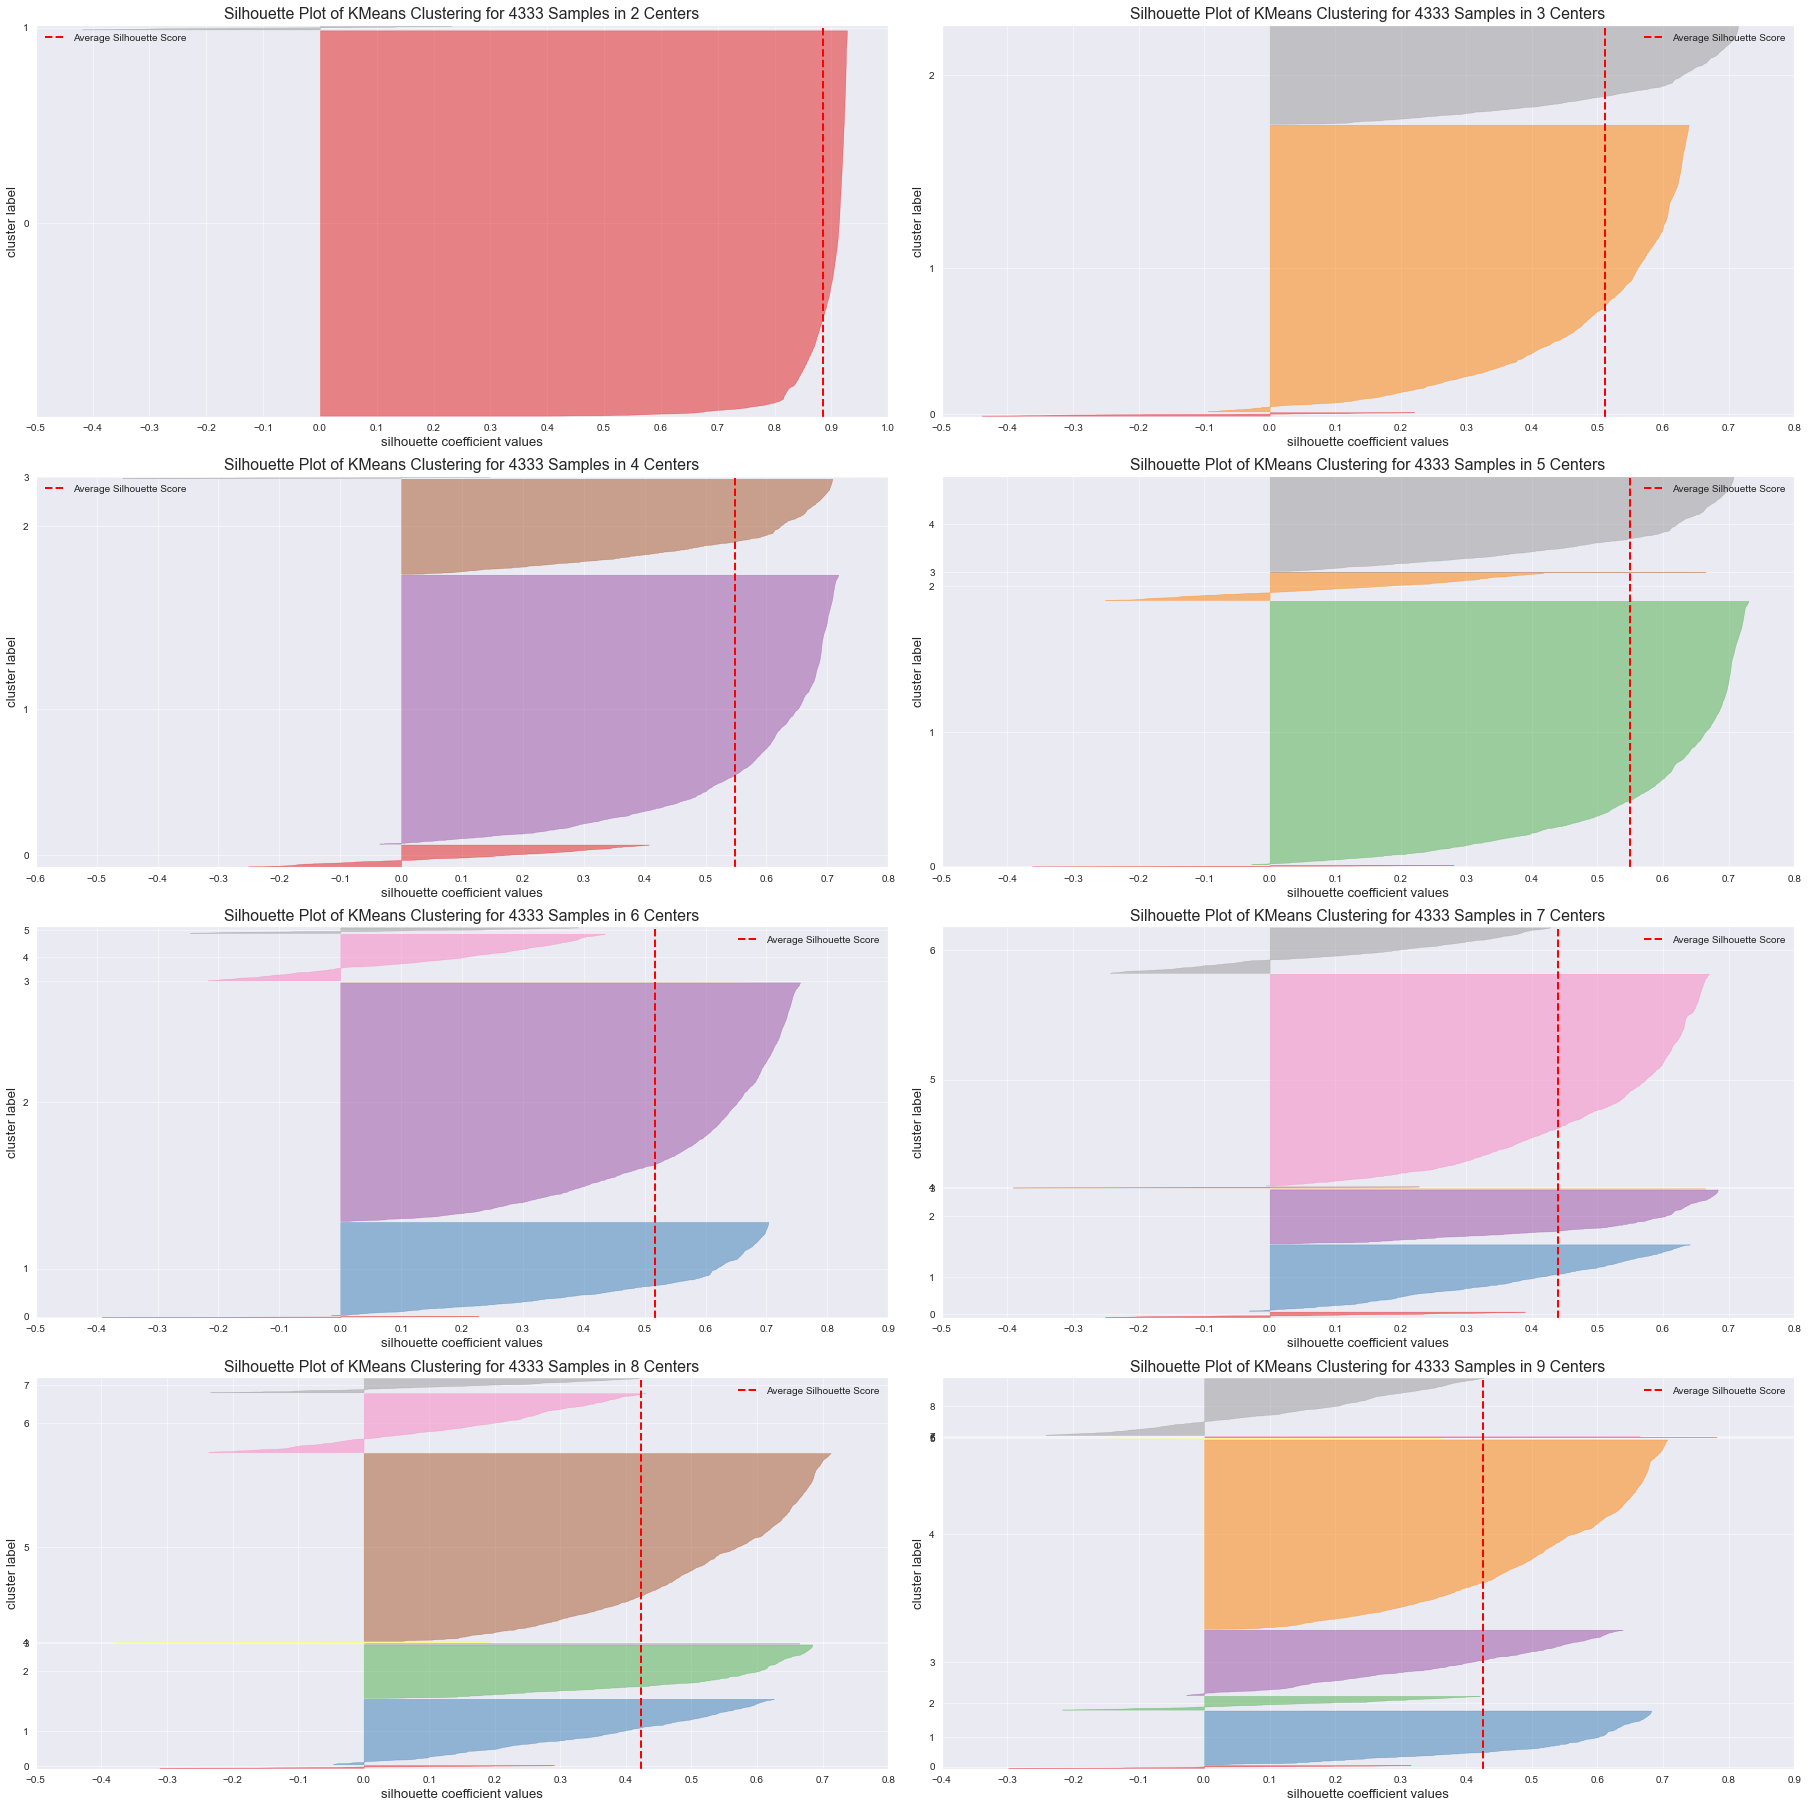

In [66]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 25), constrained_layout = True)
  

for k in clusters:
    q, mod = divmod( k, 2 )
    
    km = KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=0 )
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize();

# 9. Model Training

## 9.1. K-Means

In [67]:
# model definition
k = 5
kmeans = KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=0 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 9.2. Cluster Validation

In [68]:
# WSS 
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

# SS
print( 'SS value: {}'.format( silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 6493.497115971512
SS value: 0.5502022971120355


# 10. Cluster Analysis

In [69]:
df10 = df7.copy()
df10['cluster'] = labels
df10.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,returns,cluster
0,17850,0.370887,2.798602,3.859875,-0.034222,0.077179,4
1,13047,0.131411,-0.609844,0.743494,-0.033765,3.342047,2
2,12583,0.581063,-0.899712,1.392740,-0.026509,1.009998,2
3,13748,-0.123144,0.029864,0.094248,-0.023522,-0.389231,1
4,15100,-0.131178,2.408780,-0.165451,0.152247,1.009998,4


## 10.1. Visualization Inspection

In [70]:
#fig = px.scatter_3d( df10, x='recency_days', y='frequency', z='gross_revenue', color='cluster' )
#fig.show()

### 10.1.1. Silhouette 

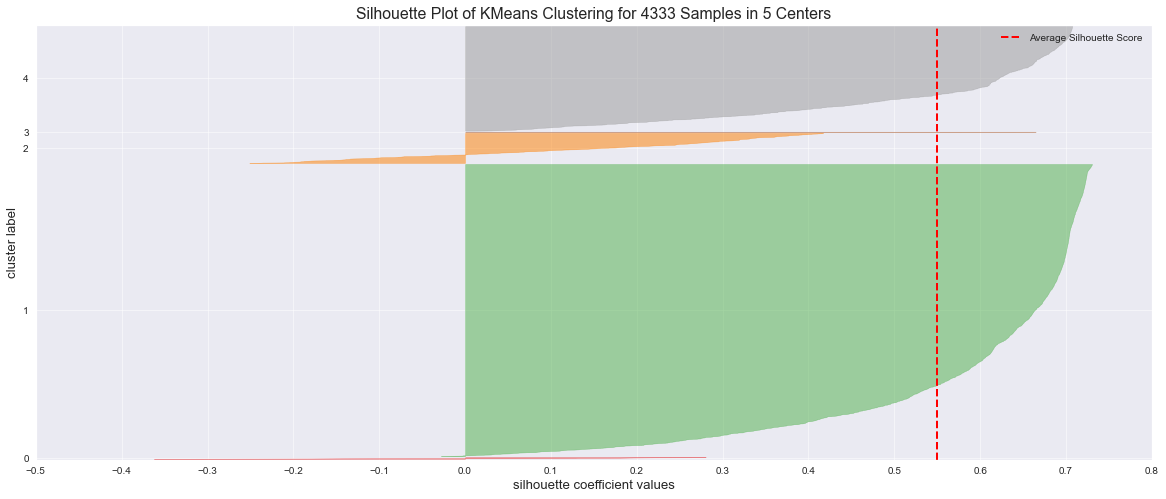

In [71]:
visualizer = SilhouetteVisualizer( kmeans, color='yellowbrick' )
visualizer.fit( X )
visualizer.finalize();

### 10.1.2. 2D Plot

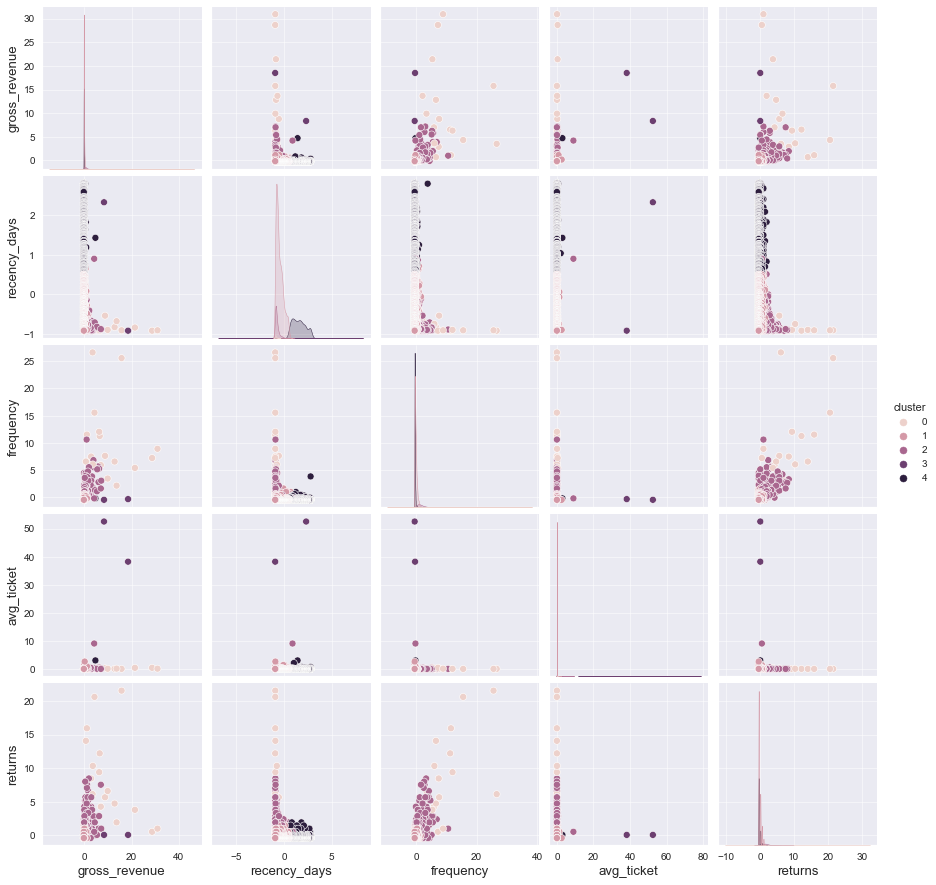

In [72]:
df_viz = df10.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )
plt.show();

### 10.1.3. UMAP

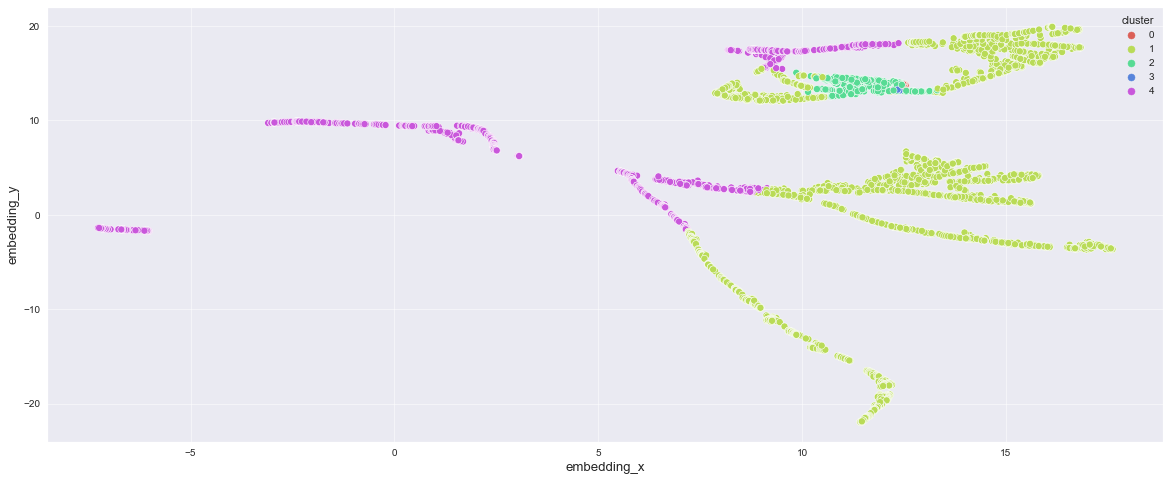

In [73]:
reducer = umap.UMAP( random_state=0, n_neighbors=40 )
embedding = reducer.fit_transform( X )

# embedding 
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y',  
                 hue='cluster', palette=sns.color_palette( 'hls', n_colors= len( df_viz['cluster'].unique() ) ), 
                 data=df_viz
               )
plt.show();

## 10.2. Cluster Profile

In [74]:
# number of customers
df_cluster = df10[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg Gross revenue
df_avg_gross_rev = df10[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_rev, how='inner', on='cluster' )

# Avg Recency days
df_avg_rec_days = df10[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_rec_days, how='inner', on='cluster' )

# Avg frequency
df_avg_invoice_no = df10[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster' )

# Avg ticket
df_avg_ticket = df10[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_ticket, how='inner', on='cluster' )

# returns
df_returns = df10[['returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns, how='inner', on='cluster' )

# rename columns
df_cluster.rename( columns={ "gross_revenue":"avg_gross_revenue", "recency_days":"avg_recency_days", "frequency":"avg_frequency", "returns":"avg_returns"}, inplace=True )

df_cluster.round(3)

,cluster,customer_id,perc_customer,avg_gross_revenue,avg_recency_days,avg_frequency,avg_ticket,avg_returns
0,0,17,0.392,10.469,-0.855,10.001,0.049,8.665
1,1,2952,68.128,-0.086,-0.480,-0.096,-0.026,-0.155
2,2,304,7.016,0.754,-0.747,1.602,0.014,1.898
3,3,2,0.046,13.429,0.705,-0.360,45.351,0.077
4,4,1058,24.417,-0.171,1.566,-0.351,-0.019,-0.253
